In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import STL as STL
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import joblib
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from arch import arch_model


In [2]:
plt.style.use('dark_background')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

## Basic Info

## Data reading

In [3]:
conn = sqlite3.connect('currencies.db')
cursor = conn.cursor()

cursor.execute("SELECT currency_id FROM 'Currencies'")
result = cursor.fetchall()
ids = [id[0] for id in result]


In [4]:
cursor.execute("SELECT DISTINCT name FROM 'Currencies'")
currency_names = cursor.fetchall()
currency_names = [currency[0] for currency in currency_names]

In [5]:
dfs = []
for id in ids:
    cursor.execute(f"SELECT date, value FROM 'ExchangeRates' WHERE currency_id = '{id}'")
    result = cursor.fetchall()
    
    dates = [r[0] for r in result]
    values = [r[1] for r in result]
    
    dfs.insert(len(dfs), pd.DataFrame(index=pd.to_datetime(dates),data= {"value":values}))


## Missing data

In [6]:
date_range = pd.date_range(start='2023-01-01', end=dfs[0].index.max(), freq='D')
dfs_daily = [None] * len(dfs)
for idx, df in enumerate(dfs):
    dfs_daily[idx] = df.reindex(date_range)
    print(f"Number of missing values for currency number {idx}: {dfs_daily[idx].isna().sum()}")

Number of missing values for currency number 0: value    163
dtype: int64
Number of missing values for currency number 1: value    163
dtype: int64
Number of missing values for currency number 2: value    163
dtype: int64
Number of missing values for currency number 3: value    163
dtype: int64
Number of missing values for currency number 4: value    163
dtype: int64
Number of missing values for currency number 5: value    163
dtype: int64
Number of missing values for currency number 6: value    163
dtype: int64
Number of missing values for currency number 7: value    163
dtype: int64
Number of missing values for currency number 8: value    163
dtype: int64
Number of missing values for currency number 9: value    163
dtype: int64
Number of missing values for currency number 10: value    163
dtype: int64
Number of missing values for currency number 11: value    163
dtype: int64
Number of missing values for currency number 12: value    163
dtype: int64
Number of missing values for curren

In [7]:
"""for i in range(len(dfs_daily)):   
    df = dfs[i]
    df_daily = dfs_daily[i]
    if df_daily.isna().sum().value > 300:
        continue
    arima_model = ARIMA(df_daily['value'], order=(5, 1, 0)).fit()
    missing_idx = df_daily.index[df_daily['value'].isna()]
    
    for idx in missing_idx:
        df_daily.loc[idx, 'arima_interpolated'] = arima_model.predict(start=str(idx.date()), end=str(idx.date()), dynamic=True)[0]
    
    residuals = arima_model.resid
    garch_model = arch_model(residuals.dropna(), vol='Garch', p=1, q=1).fit(disp='off')
    
    df_daily['garch_interpolated'] = df_daily['arima_interpolated']
    for idx in missing_idx:
        pred_var = garch_model.forecast(start=idx, horizon=1).variance.values[-1, 0]
    
        df_daily.loc[idx, 'garch_interpolated'] = df_daily.loc[idx, 'arima_interpolated'] + np.sqrt(pred_var)
    
    df_daily['value'] = df_daily['value'].combine_first(df_daily['garch_interpolated'])
    dfs[i] = df_daily
    dfs[i].drop(columns=["arima_interpolated", "garch_interpolated"], inplace=True)
    """

'for i in range(len(dfs_daily)):   \n    df = dfs[i]\n    df_daily = dfs_daily[i]\n    if df_daily.isna().sum().value > 300:\n        continue\n    arima_model = ARIMA(df_daily[\'value\'], order=(5, 1, 0)).fit()\n    missing_idx = df_daily.index[df_daily[\'value\'].isna()]\n    \n    for idx in missing_idx:\n        df_daily.loc[idx, \'arima_interpolated\'] = arima_model.predict(start=str(idx.date()), end=str(idx.date()), dynamic=True)[0]\n    \n    residuals = arima_model.resid\n    garch_model = arch_model(residuals.dropna(), vol=\'Garch\', p=1, q=1).fit(disp=\'off\')\n    \n    df_daily[\'garch_interpolated\'] = df_daily[\'arima_interpolated\']\n    for idx in missing_idx:\n        pred_var = garch_model.forecast(start=idx, horizon=1).variance.values[-1, 0]\n    \n        df_daily.loc[idx, \'garch_interpolated\'] = df_daily.loc[idx, \'arima_interpolated\'] + np.sqrt(pred_var)\n    \n    df_daily[\'value\'] = df_daily[\'value\'].combine_first(df_daily[\'garch_interpolated\'])\n    df

In [7]:
for i in range(33, len(dfs_daily)):
    dfs[i] = pd.DataFrame(dfs_daily[i]["value"].interpolate(method="spline", order=3))
    dfs[i].dropna(inplace=True)

## EDA

In [8]:
def time_plotter(function):
    
    cursor.execute(f"SELECT currency_id FROM 'Currencies' WHERE name = '{function}'")
    currency_id = cursor.fetchone()[0]    
    fig, ax = plt.subplots(figsize=(8,4))
    dfs[currency_id][dfs[currency_id].columns[0]].plot(ax=ax)
    ax.set_ylabel("value")
    ax.set_title(f"Value of {currency_names[currency_id]} over time")
    ax.set_xlabel("Date")
    ax.legend().set_visible(False)
    plt.show()
    
dropdown = widgets.Dropdown(
    options= currency_names,
    value='euro',
    description='Choose currency:'
)

interact(time_plotter, function=dropdown)
    

interactive(children=(Dropdown(description='Choose currency:', index=7, options=('bat (Tajlandia)', 'dolar ame…

<function __main__.time_plotter(function)>

In [9]:
def acf_plotter(lags, function):
    cursor.execute(f"SELECT currency_id FROM 'Currencies' WHERE name = '{function}'")
    currency_id = cursor.fetchone()[0]  
    fig, ax = plt.subplots(figsize=(12,6))
    plot_acf(dfs[currency_id][dfs[currency_id].columns[0]], lags=lags, ax=ax)
    ax.set_title(f"Autocorrelation for {function}")
    plt.grid()
    plt.show()
    
dropdown = widgets.Dropdown(
    options= currency_names,
    value='euro',
    description='Choose currency:'
)

interact(acf_plotter, lags=150, function=dropdown)

interactive(children=(IntSlider(value=150, description='lags', max=450, min=-150), Dropdown(description='Choos…

<function __main__.acf_plotter(lags, function)>

In [10]:
def pcf_plotter(lags, function):
    cursor.execute(f"SELECT currency_id FROM 'Currencies' WHERE name = '{function}'")
    currency_id = cursor.fetchone()[0]
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_pacf(dfs[currency_id], lags=lags, ax=ax)
    ax.set_title(f"Partial autocorrelation for {function}")
    plt.grid()
    plt.show()

interact(pcf_plotter, lags=150, function=dropdown)

interactive(children=(IntSlider(value=150, description='lags', max=450, min=-150), Dropdown(description='Choos…

<function __main__.pcf_plotter(lags, function)>

In [11]:
def shift_feature(data, shifts):
    for shift in shifts:
        data[f"shift_{shift}"] = data[data.columns[0]].shift(shift)


In [12]:
for i in range(len(dfs)):
    shift_feature(dfs[i], [1,2])
dfs[0]


,value,shift_1,shift_2
2023-01-02,0.1267,NaN,NaN
2023-01-03,0.1290,0.1267,NaN
2023-01-04,0.1292,0.1290,0.1267
2023-01-05,0.1295,0.1292,0.1290
2023-01-09,0.1314,0.1295,0.1292
...,...,...,...
2024-05-28,0.1070,0.1071,0.1073
2024-05-29,0.1068,0.1070,0.1071
2024-05-31,0.1070,0.1068,0.1070
2024-06-03,0.1072,0.1070,0.1068


In [13]:
def rolling_window(windowsize, function):
    cursor.execute(f"SELECT currency_id FROM 'Currencies' WHERE name = '{function}'")
    currency_id = cursor.fetchone()[0]
    
    fig, ax = plt.subplots(figsize=(8,4))
    plt.plot(dfs[currency_id].index, dfs[currency_id][dfs[currency_id].columns[0]].rolling(window=windowsize).mean(),label="rolling window")
    plt.plot(dfs[currency_id].index, dfs[currency_id][dfs[currency_id].columns[0]], alpha=0.5, label="data")
    ax.set_xlabel("Data")
    ax.set_ylabel("PM2.5")
    ax.set_title(f"Value of {function} and its moving average")
    ax.legend()
    plt.grid()
    plt.show()

dropdown = widgets.Dropdown(
    options= currency_names,
    value='euro',
    description='Choose currency:'
)

interact(rolling_window, windowsize=7, function=dropdown)


interactive(children=(IntSlider(value=7, description='windowsize', max=21, min=-7), Dropdown(description='Choo…

<function __main__.rolling_window(windowsize, function)>

In [14]:
def mean_rolling(data, window_sizes):
    for window in window_sizes:
        data[f"rolling_{window}_mean"] = (data[data.columns[0]].shift(1).
                                          rolling(window=window).mean())


In [15]:
def std_rolling(data, window_sizes):
    for window in window_sizes:
        data[f"rolling_{window}_std"] = (data[data.columns[0]].shift(1).
                                         rolling(window=window).std())

In [16]:
 for i in range(len(dfs)):
    mean_rolling(dfs[i], [2,3])
    std_rolling(dfs[i], [2,3])
dfs[0]


,value,shift_1,shift_2,rolling_2_mean,rolling_3_mean,rolling_2_std,rolling_3_std
2023-01-02,0.1267,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,0.1290,0.1267,NaN,NaN,NaN,NaN,NaN
2023-01-04,0.1292,0.1290,0.1267,0.12785,NaN,0.001626,NaN
2023-01-05,0.1295,0.1292,0.1290,0.12910,0.128300,0.000141,0.001389
2023-01-09,0.1314,0.1295,0.1292,0.12935,0.129233,0.000212,0.000252
...,...,...,...,...,...,...,...
2024-05-28,0.1070,0.1071,0.1073,0.10720,0.107433,0.000141,0.000416
2024-05-29,0.1068,0.1070,0.1071,0.10705,0.107133,0.000071,0.000153
2024-05-31,0.1070,0.1068,0.1070,0.10690,0.106967,0.000141,0.000153
2024-06-03,0.1072,0.1070,0.1068,0.10690,0.106933,0.000141,0.000115


In [17]:
def shifted_diff(data, num_lags):
    for i in range(1, num_lags + 1):
        data[f'value_lag_{i}'] = data[data.columns[0]].diff(periods=i)

In [18]:
for i in range(len(dfs)):
    shifted_diff(dfs[i],2)
dfs[0]

,value,shift_1,shift_2,rolling_2_mean,rolling_3_mean,rolling_2_std,rolling_3_std,value_lag_1,value_lag_2
2023-01-02,0.1267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,0.1290,0.1267,NaN,NaN,NaN,NaN,NaN,0.0023,NaN
2023-01-04,0.1292,0.1290,0.1267,0.12785,NaN,0.001626,NaN,0.0002,0.0025
2023-01-05,0.1295,0.1292,0.1290,0.12910,0.128300,0.000141,0.001389,0.0003,0.0005
2023-01-09,0.1314,0.1295,0.1292,0.12935,0.129233,0.000212,0.000252,0.0019,0.0022
...,...,...,...,...,...,...,...,...,...
2024-05-28,0.1070,0.1071,0.1073,0.10720,0.107433,0.000141,0.000416,-0.0001,-0.0003
2024-05-29,0.1068,0.1070,0.1071,0.10705,0.107133,0.000071,0.000153,-0.0002,-0.0003
2024-05-31,0.1070,0.1068,0.1070,0.10690,0.106967,0.000141,0.000153,0.0002,0.0000
2024-06-03,0.1072,0.1070,0.1068,0.10690,0.106933,0.000141,0.000115,0.0002,0.0004


In [19]:
def stl_plotter(data):
    stl = STL(data[data.columns[0]], period=10).fit()
    stl.plot()
    monthly_data = data.resample('M')[data.columns[0]].mean()
    plt.xticks(monthly_data.index, range(1,19))
    plt.xlabel("Month")
    plt.show()
    return stl


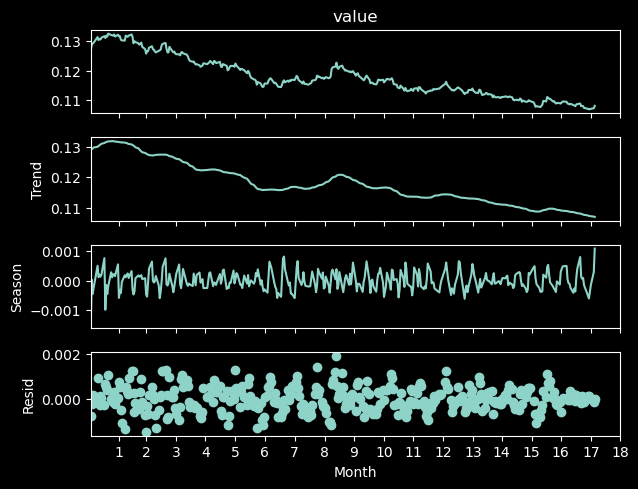

In [20]:
 stl_plotter(dfs[0])

In [21]:
def stl_components(data):
    stl = STL(data[data.columns[0]],period=10).fit()
    data["trend"] = stl.trend
    data["seasonal"] = stl.seasonal
    data["resid"] = stl.resid

In [22]:
for i in range(len(dfs)):
    stl_components(dfs[i])
dfs[0]

,value,shift_1,shift_2,rolling_2_mean,rolling_3_mean,rolling_2_std,rolling_3_std,value_lag_1,value_lag_2,trend,seasonal,resid
2023-01-02,0.1267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.128941,-0.001479,-0.000763
2023-01-03,0.1290,0.1267,NaN,NaN,NaN,NaN,NaN,0.0023,NaN,0.129206,0.000030,-0.000237
2023-01-04,0.1292,0.1290,0.1267,0.12785,NaN,0.001626,NaN,0.0002,0.0025,0.129468,-0.000442,0.000174
2023-01-05,0.1295,0.1292,0.1290,0.12910,0.128300,0.000141,0.001389,0.0003,0.0005,0.129726,-0.000233,0.000007
2023-01-09,0.1314,0.1295,0.1292,0.12935,0.129233,0.000212,0.000252,0.0019,0.0022,0.129982,0.000501,0.000917
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-28,0.1070,0.1071,0.1073,0.10720,0.107433,0.000141,0.000416,-0.0001,-0.0003,0.107384,-0.000516,0.000132
2024-05-29,0.1068,0.1070,0.1071,0.10705,0.107133,0.000071,0.000153,-0.0002,-0.0003,0.107273,-0.000603,0.000131
2024-05-31,0.1070,0.1068,0.1070,0.10690,0.106967,0.000141,0.000153,0.0002,0.0000,0.107161,-0.000144,-0.000017
2024-06-03,0.1072,0.1070,0.1068,0.10690,0.106933,0.000141,0.000115,0.0002,0.0004,0.107049,0.000287,-0.000136


In [23]:
def rolling_window_plotter(data):
    window_sizes = range(30, 365, 30)
    plt.figure(figsize=(10, 6))
    for window_size in window_sizes:
        rolling_mean = data[data.columns[0]].expanding(min_periods=window_size).mean()
        plt.plot(rolling_mean.index, rolling_mean.values,
                 label=f'Window Size:{window_size} days')
    plt.xlabel('Date')
    plt.ylabel('Rolling Mean')
    plt.legend(loc="upper right")
    plt.title('Rolling Mean with Expanding Windows')
    plt.show()


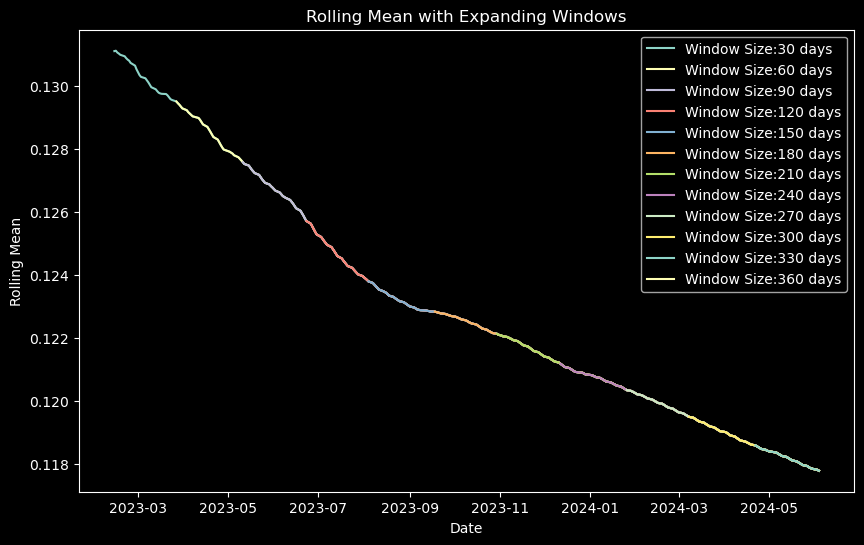

In [24]:
rolling_window_plotter(dfs[0])

In [25]:
def expanding_window(data):
    data[f"expanding_mean_{1}"] = data.shift(1)[data.columns[0]].expanding().mean()


In [26]:
for i in range(len(dfs)):
    expanding_window(dfs[i])
dfs[0]

,value,shift_1,shift_2,rolling_2_mean,rolling_3_mean,rolling_2_std,rolling_3_std,value_lag_1,value_lag_2,trend,seasonal,resid,expanding_mean_1
2023-01-02,0.1267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.128941,-0.001479,-0.000763,NaN
2023-01-03,0.1290,0.1267,NaN,NaN,NaN,NaN,NaN,0.0023,NaN,0.129206,0.000030,-0.000237,0.126700
2023-01-04,0.1292,0.1290,0.1267,0.12785,NaN,0.001626,NaN,0.0002,0.0025,0.129468,-0.000442,0.000174,0.127850
2023-01-05,0.1295,0.1292,0.1290,0.12910,0.128300,0.000141,0.001389,0.0003,0.0005,0.129726,-0.000233,0.000007,0.128300
2023-01-09,0.1314,0.1295,0.1292,0.12935,0.129233,0.000212,0.000252,0.0019,0.0022,0.129982,0.000501,0.000917,0.128600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-28,0.1070,0.1071,0.1073,0.10720,0.107433,0.000141,0.000416,-0.0001,-0.0003,0.107384,-0.000516,0.000132,0.117931
2024-05-29,0.1068,0.1070,0.1071,0.10705,0.107133,0.000071,0.000153,-0.0002,-0.0003,0.107273,-0.000603,0.000131,0.117901
2024-05-31,0.1070,0.1068,0.1070,0.10690,0.106967,0.000141,0.000153,0.0002,0.0000,0.107161,-0.000144,-0.000017,0.117869
2024-06-03,0.1072,0.1070,0.1068,0.10690,0.106933,0.000141,0.000115,0.0002,0.0004,0.107049,0.000287,-0.000136,0.117839


In [27]:
def relative_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mean_y_true = np.mean(y_true)
    return np.mean(np.abs((y_true - y_pred) / mean_y_true)) * 100

In [28]:
def cross_validation_splitter(data, cv_points):
    cv_res_list = []
    for cv_point in cv_points:
        break_point = int(len(dfs[0])*cv_point)
        before_breakpoint = [i for i in range(break_point)]
        after_breakpoint = [i for i in range(break_point, len(data))]
        cv_res_list.append([before_breakpoint, after_breakpoint])
    return cv_res_list


In [29]:
scoring = make_scorer(mean_squared_error, greater_is_better=False)
cv_split = cross_validation_splitter(dfs[0], [0.6, 0.65, 0.7, 0.75, 0.8])

param_grid = {
#'max_depth': [2,3,5],
#'learning_rate': [0.01, 0.05, 0.1], 
#'min_child_weight': [1,2,3]
    'max_depth': [7],
    'learning_rate': [0.4],
    'min_child_weight': [1]
}

best_models = [None] * len(dfs)
best_params = [None] * len(dfs)
importance = [None] * len(dfs)
best_split = [None] * len(dfs)
mae = [None] * len(dfs)
rmape = [None] * len(dfs) 
predictions = [None] * len(dfs)

for i in range(len(dfs)):
    print(f"Currency number {i}")
    mae_min = 1e30
    for train_index, test_index in cv_split:   
        X_train = dfs[i].iloc[train_index, 1:]
        X_test = dfs[i].iloc[test_index, 1:]
        y_train = dfs[i].iloc[train_index, 0]
        y_test = dfs[i].iloc[test_index, 0]

        xgb_model = XGBRegressor()
        grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring=scoring)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred = grid_search.predict(X_test)
        
        mae_val = mean_absolute_error(y_test, y_pred)
        
        if mae_val < mae_min:
            mae_min = mae_val
            best_models[i] = best_model
            best_params[i] = grid_search.best_params_
            #importance[i] = best_model.feature_importances
            best_split[i] = f"{round(len(train_index)/len(dfs[i]),2)*100}/{100-round(len(train_index)/len(dfs[i]),2)*100}"
            mae[i] = mae_val
            rmape[i] = relative_mape(y_test, y_pred)
            predictions[i] = y_pred
    

Currency number 0
Currency number 1
Currency number 2
Currency number 3
Currency number 4
Currency number 5
Currency number 6
Currency number 7
Currency number 8
Currency number 9
Currency number 10
Currency number 11
Currency number 12
Currency number 13
Currency number 14
Currency number 15
Currency number 16
Currency number 17
Currency number 18
Currency number 19
Currency number 20
Currency number 21
Currency number 22
Currency number 23
Currency number 24
Currency number 25
Currency number 26
Currency number 27
Currency number 28
Currency number 29
Currency number 30
Currency number 31
Currency number 32
Currency number 33
Currency number 34
Currency number 35
Currency number 36
Currency number 37
Currency number 38
Currency number 39
Currency number 40
Currency number 41
Currency number 42
Currency number 43
Currency number 44
Currency number 45
Currency number 46
Currency number 47
Currency number 48
Currency number 49
Currency number 50
Currency number 51
Currency number 52
Cur

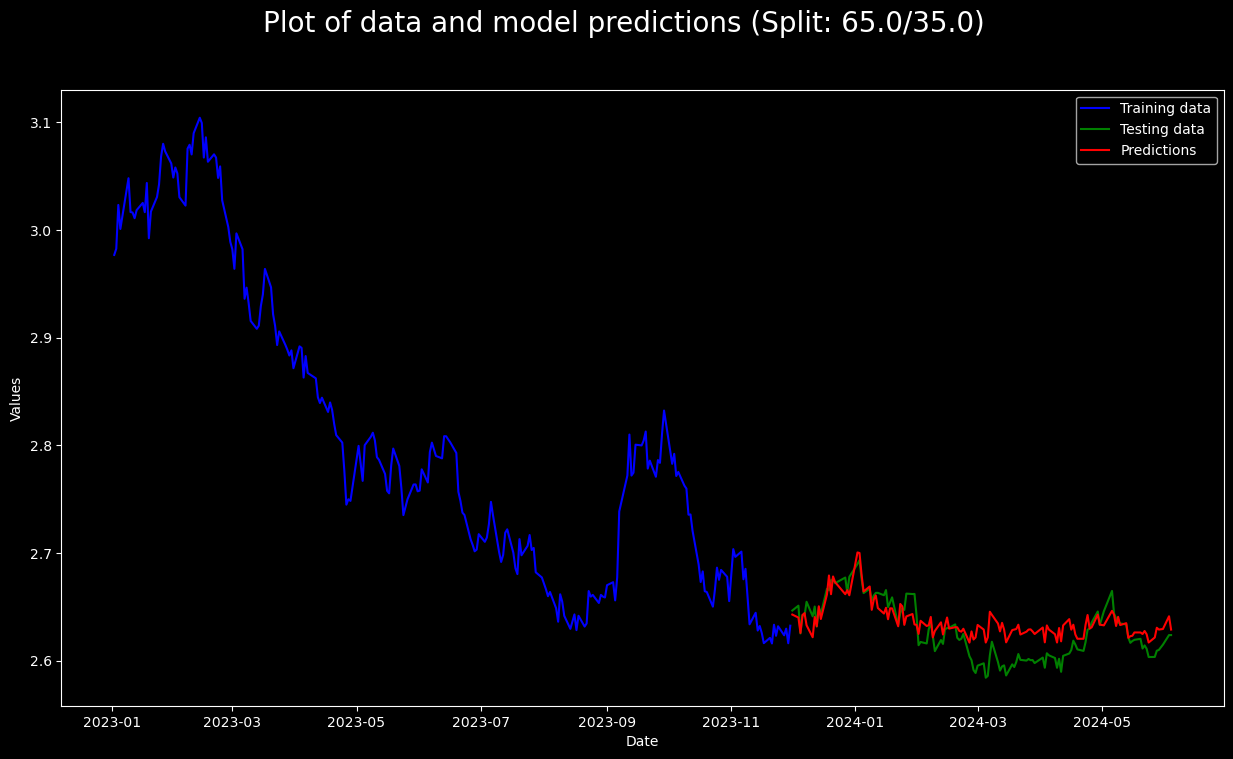

In [32]:
split_ratios = [tuple(map(float, split.split('/'))) for split in best_split]
split_ratio = split_ratios[2]
split_point = int(len(dfs[2]) * split_ratio[0] / 100)  # Calculate split point based on ratio
train_data = dfs[2].iloc[:split_point]
test_data = dfs[2].iloc[split_point:]

    # Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 8))
fig.suptitle(f'Plot of data and model predictions (Split: {split_ratio[0]}/{split_ratio[1]})', size=20)
ax.set_xlabel('Date')
ax.set_ylabel('Values')

ax.plot(train_data.index, train_data[train_data.columns[0]], label="Training data", color='blue')

ax.plot(test_data.index, test_data[test_data.columns[0]], label="Testing data", color='green')
    # Plot predictions
ax.plot(test_data.index, predictions[2], label="Predictions", color='red')
ax.legend()

plt.show()

In [33]:
med_rmape_vals = [np.median(rmape[i]) for i in range(len(rmape))]
for idx, curr in enumerate(currency_names):
    print(f"median RMAPE value for {curr}: {med_rmape_vals[idx]}")
print("general median for talbe 'a' currencies :", np.median(med_rmape_vals[0:33]))
print("general median for talbe 'b' currencies :", np.mean(med_rmape_vals[33:]))

median RMAPE value for bat (Tajlandia): 2.4828661929784857
median RMAPE value for dolar amerykański: 0.22628652279048397
median RMAPE value for dolar australijski: 0.561946506347097
median RMAPE value for dolar Hongkongu: 0.27726510586344816
median RMAPE value for dolar kanadyjski: 0.4377904007999842
median RMAPE value for dolar nowozelandzki: 0.617060437160848
median RMAPE value for dolar singapurski: 0.6462759616119799
median RMAPE value for euro: 0.4435761649075005
median RMAPE value for forint (Węgry): 4.026066678907242
median RMAPE value for frank szwajcarski: 1.4234328525429683
median RMAPE value for funt szterling: 0.2032826345984911
median RMAPE value for hrywna (Ukraina): 2.1316030938592863
median RMAPE value for jen (Japonia): 2.545256035529844
median RMAPE value for korona czeska: 0.6827419625563653
median RMAPE value for korona duńska: 0.512383791602073
median RMAPE value for korona islandzka: 0.7204388437430872
median RMAPE value for korona norweska: 0.3468858432696854
med

In [34]:
model_med_rmape_values = pd.DataFrame({"currency": currency_names, "rmape":med_rmape_vals})
model_med_rmape_values.to_csv('model_rmape.csv')

In [35]:
from pathlib import Path
for i, model in enumerate(best_models):
    filename = f'model_{i}.joblib'  # Adjust the filename as needed
    joblib.dump(model, Path.cwd() / "models" / filename)